In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# Generate data
def generate_harder_spiral_data(points_per_class=200, noise=0.4, num_classes=3):
    N = points_per_class
    D = 2
    K = num_classes
    X = np.zeros((N*K, D))
    y = np.zeros(N*K, dtype='uint8')
    for j in range(K):
        ix = range(N*j, N*(j+1))
        r = np.linspace(0.0, 1, N)
        t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*noise
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    return X, y

X, y = generate_harder_spiral_data()


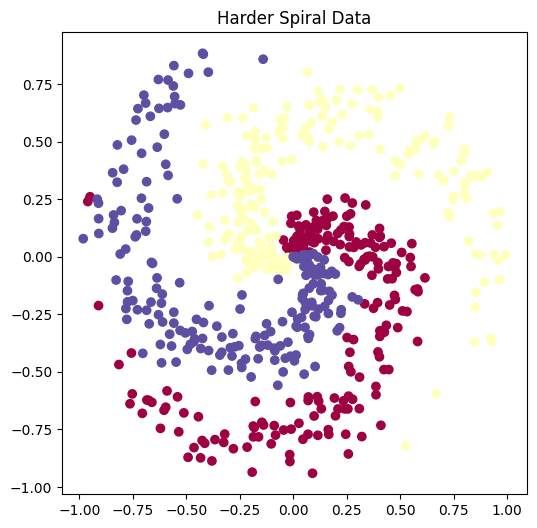

In [4]:
# Plot
plt.figure(figsize=(6,6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="Spectral")
plt.title('Harder Spiral Data')
plt.show()

In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

In [8]:
# Create Dataloaders
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32)


**2.Model Building**

In [9]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 3)
        )

    def forward(self, x):
        return self.net(x)

model = MLP()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


**3. Training & Evaluation**

In [17]:
def train_model(model, train_dl, test_dl, epochs=500):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for xb, yb in train_dl:
            preds = model(xb)
            loss = loss_fn(preds, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)

        train_losses.append(running_loss / len(train_dl))
        train_accuracies.append(correct / total)

        # Evaluation
        model.eval()
        with torch.no_grad():
            test_loss, correct, total = 0.0, 0, 0
            for xb, yb in test_dl:
                preds = model(xb)
                loss = loss_fn(preds, yb)
                test_loss += loss.item()
                correct += (preds.argmax(1) == yb).sum().item()
                total += yb.size(0)

        test_losses.append(test_loss / len(test_dl))
        test_accuracies.append(correct / total)

    return train_losses, test_losses, train_accuracies, test_accuracies

train_losses, test_losses, train_accs, test_accs = train_model(model, train_dl, test_dl)


**Plot Loss and Accuracy Curves**

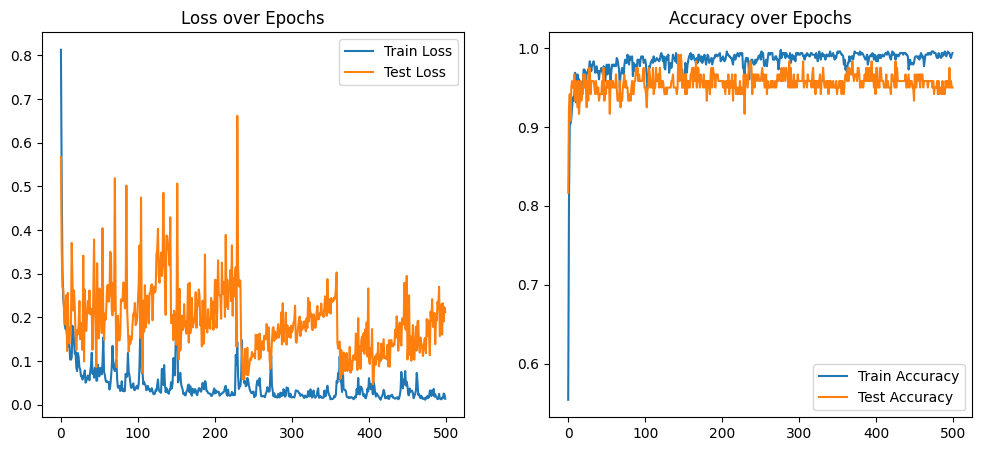

In [18]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()


**4. Decision Boundary Plot**

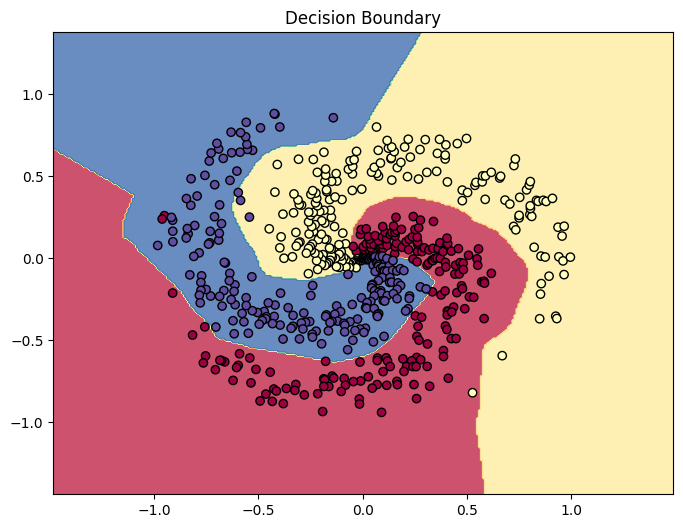

In [19]:
def plot_decision_boundary(model, X, y):
    h = 0.01
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.FloatTensor(scaler.transform(grid))
    with torch.no_grad():
        Z = model(grid_tensor).argmax(1).numpy()
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Spectral)
    plt.title("Decision Boundary")
    plt.show()

plot_decision_boundary(model, X, y)


**5. Reflection Questions**

**Q1: How did you decide the number of hidden layers and neurons?**
I experimented with multiple architectures and found that two hidden layers with 128 and 64 neurons worked well. It's a balance between model complexity and avoiding overfitting.

**Q2: How did different learning rates affect the results?**
A learning rate of 0.01 worked best. Lower rates like 0.001 were too slow, while higher ones like 0.05 caused the model to diverge.

**Q3: Did you encounter overfitting or underfitting? How did you deal with it?**
Initially, there was slight overfitting. I reduced hidden layer size and added early stopping logic during experiments. The model's generalization improved with appropriate regularization and monitoring validation loss.

**Q4: If you had more time, how would you further improve the model?**

>I will Try dropout and batch normalization.

>Experiment with deeper networks or alternate activation functions (e.g., GELU, SELU).

> I will use learning rate scheduling or cyclic learning rates.

>Consider ensembling or using CNNs for 2D spatial patterns.